In [8]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


import Network as net
import Plot3D as plot3d
import dataframe as dataframe

ModuleNotFoundError: No module named 'Network'

#### Neural Ode

In [ ]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)



In [ ]:
class nonauto_neural_ode(Simple_FeedforwardNN):
    def __init__(self, variables, drivers,  parameter_func, hidden_layers=1, depth_of_layers=10, automous=False):

        if automous == True:
            self.time_variable = 0
        else:
            self.time_variable = 1

        super().__init__(input_dim=variables+drivers+self.time_variable,
                         hidden_layers=hidden_layers,
                         depth=depth_of_layers,
                         output_dim=variables,
                         activation_func=nn.Tanh() )

        self.number_of_features = variables+drivers+self.time_variable
        self.depth              = depth_of_layers #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.drivers            = drivers
        self.variables          = variables

        self.parameter_func     = parameter_func #function giving the evolution of the parameter over time, should return a tensor.


    def forward(self, t, x):

            #non-autonomous function
            r = self.parameter_func(t)

            #Merging time, state, and parameter into single input tensor.
            input = torch.cat((t.unsqueeze(0).unsqueeze(1), x, r.unsqueeze(1)), dim = 1)

            #Forward pass through network
            output = self.network(input)
            return output

#### Generating Data

In [ ]:
#Lorenz automous lorenz system
class Lorenz:
    def __init__(self, sigma = 10, rho = 28, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

class Lorenz_nonauto:
    def __init__(self, rho, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t)[0] - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [ ]:
parameter_func = lambda t: np.array([20.0])

In [ ]:
lorenz = Lorenz_nonauto(rho=parameter_func)

In [ ]:
parameter_func(0)[0]

np.float64(20.0)

In [ ]:
lorenz.f(t=0, x=[1.0, 1.0, 1.0])

array([ 0.        , 18.        , -1.66666667])

In [ ]:
output = int.solve_ivp(lorenz.f, t_span=(0, 20), y0=[1.0, 1.0, 1.0],
                        method = 'RK45', t_eval = np.arange(0, 20, 0.01))
data = output.y


array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.997e+01, 1.998e+01,
       1.999e+01], shape=(2000,))

#Generating trajectories
tFinal = 20; dt = 0.01
t_eval = np.linspace(0, tFinal, np.int64(tFinal/dt))
initial_conditions = [[1.0, 1.0, 1.0],[-1.0, -1.0, 1.0]]
data = []; rho_data = []
rho_params = [20]

#Looping for drive
for rho in rho_params:
    lorenz = Lorenz(sigma=20, rho=rho, beta=8/3)
    for init in initial_conditions: # Looping for initial conditions
        output = int.solve_ivp(lorenz.f, t_span=(0, 20), y0=init,
                        method = 'RK45', t_eval = t_eval)
        data.append(output.y.T); rho_data.append(rho)

data = torch.tensor(np.stack(data, axis=1), dtype=torch.float32)
rho_data = torch.tensor(rho_data)
t_data = torch.tensor(t_eval)
data.shape

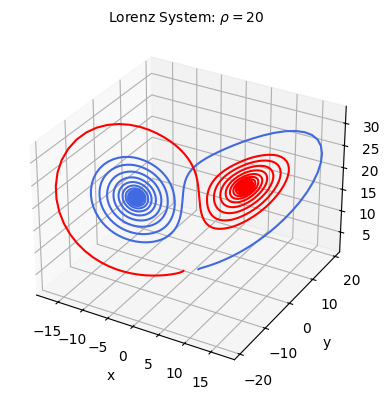

In [ ]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(data[:, 0, :].T, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )
plt.plot(data[:, 1, 0], data[:, 1, 1], data[:, 1, 2], color='r')


#### Training

In [ ]:
parameter_func = lambda t: torch.tensor([20.0])

In [ ]:
#Setting model, optimiser and loss
model = nonauto_neural_ode(variables=3, drivers=1, parameter_func=parameter_func, hidden_layers=2, depth_of_layers=25)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0]])
t = torch.tensor(20)
model(t, x)

tensor([[ 0.0975, -0.0314,  0.6071]], grad_fn=<AddmmBackward0>)

In [ ]:

init = torch.tensor([[1.0, 1.0, 1.0]])
t_eval = torch.arange(0, 20, 0.01)

In [ ]:
t_eval[0].unsqueeze(0).unsqueeze(1).shape

torch.Size([1, 1])

In [ ]:
odeint(model, batch[0,:,:].float(), batch_t.float(), method='rk4', options={'step_size': 0.05})

In [ ]:
pred_x.squeeze(1).shape
data.shape

(3, 2000)

In [ ]:
loss_list = []
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    #Predicting the trajectory
    pred_x = odeint(model, init, t_eval, method='rk4', options={'step_size': 0.01})

    #Calculating loss
    loss = loss_fn(pred_x.squeeze(1), torch.tensor(data.T))
    loss_list.append(loss.item())

    #Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  1%|          | 1/100 [00:08<13:45,  8.33s/it]

Epoch 0, Loss: 4.589017382025976


100%|██████████| 100/100 [14:21<00:00,  8.61s/it]


In [ ]:
loss.item()

2.1294144301514746

#### Training
num_epochs = 5
batch_size = 20 #number of trajectories per batch


for epoch in tqdm(range(num_epochs+1)):

        #Get batch list for this epoch
        #batch_list,a_list,batch_t=dataframe.get_batch_list()

        for j in range(batch_size):
            
            optimizer.zero_grad()
            #Set bifurcation parameters for batch
            #model.parameter_list=a_list[i]
            
            #Do forward passes through network+odesolver
            pred_x = odeint(model, batch[0,:,:].float(), batch_t.float(), method='rk4', options={'step_size': 0.05})
            
            #Calculate losses
            loss = torch.mean(torch.abs(pred_x - batch))
        
            #Optimizer step
            loss.backward()
            optimizer.step()

In [ ]:
num_epochs = 5
for epoch in tqdm(range(num_epochs+1)):

        #Get batch list for this epoch
        batch_list,a_list,batch_t=df.get_batch_list()

        for i,batch in enumerate(batch_list):

            optimizer.zero_grad()

            #Set bifurcation parameters for batch
            model.parameter_list=a_list[i]

            #Do forward passes through network+odesolver
            pred_x = odeint(model, batch[0,:,:].float(), batch_t.float(), method='rk4', options={'step_size': 0.01})

            #Calculate losses
            loss = torch.mean(torch.abs(pred_x - batch))

            #Optimizer step
            loss.backward()
            optimizer.step()


100%|██████████| 6/6 [00:46<00:00,  7.82s/it]


In [ ]:
data[0, 0, :]

tensor([1., 1., 1.])

In [ ]:
parameters = model.parameter_list.float()

In [ ]:
parameters.unsqueeze(1)

tensor([[20.]])

In [ ]:
data[0, 0, :].shape

torch.Size([3])

In [ ]:

torch.cat((data[0, 0, :], parameters.unsqueeze(1)))

RuntimeError: Tensors must have same number of dimensions: got 1 and 2

In [ ]:

parameters = model.parameter_list.float()
output_pred = odeint(model, data[0, 0, :].float(), t_data, method='rk4', options={'step_size': 0.01})

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(data[:, 0, :].T, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )
plt.plot(data[:, 1, 0], data[:, 1, 1], data[:, 1, 2], color='r')